In [1]:
#Libraries
import re
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import keras
from keras.models import load_model
from keras.layers import *
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras import backend as K
from keras import layers
from keras import Model

In [2]:
def processed_data(data):
    data=data.drop(columns=["Unnamed: 0"])
    data['Utterances'] = data['Utterances'].apply(lambda x: x.lower())
    data['Utterances'] = data['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

    y = pd.get_dummies(data['Basic']).values

    return data,y

In [3]:
def DA_label_count(data):
    label_count=data.groupby('Basic')['Basic'].agg('count')
    label_count.to_numpy(dtype=int)
    label_count = np.expand_dims(label_count, axis=0)
    label_count.shape=(5,1)
    labels=np.array(['B', 'D', 'F', 'Q', 'S'])
    labels.shape=(5,1)
    label_count=np.column_stack((labels,label_count))
    df = pd.DataFrame(label_count, columns=['Label', 'Count'])
    convert_dict = {
                    'Label': str,
                    'Count': int
                   }  
    df = df.astype(convert_dict)
    return df

In [5]:
path = "D://repo//DAC//datasets//MRDA//"

In [6]:
full_data = pd.read_csv(path+"full_set.csv")
MAX_PADDING = 100
def x_value(data):
    tokenizer = Tokenizer(num_words = 5000, split=" ")
    tokenizer.fit_on_texts(full_data['Utterances'].values)
    x = tokenizer.texts_to_sequences(data['Utterances'].values)
    x = pad_sequences(x, padding='post', maxlen=MAX_PADDING)
    
    return x

In [7]:
train_data = pd.read_csv(path+'train.csv')
train_data,y_train = processed_data(train_data)
x_train = x_value(train_data)

val_data = pd.read_csv(path+'val.csv')
val_data,y_val = processed_data(val_data)
x_val = x_value(val_data)

test_data = pd.read_csv(path+'test.csv')
test_data,y_test = processed_data(test_data)
x_test = x_value(test_data)

In [8]:
filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(x_train) # 43,731
MAX_LENGTH = 100

EMBED_SIZE = 256 # arbitary
UNIQUE_DA = 5

# CNN model
inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE+1, 
                      output_dim=EMBED_SIZE, 
                      input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions
conv_0 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[0], EMBED_SIZE), 
                strides=1, 
                padding='valid', 
                kernel_initializer='normal', 
                activation='relu')(reshape)

bn_0 = BatchNormalization()(conv_0)

conv_1 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[1], EMBED_SIZE), 
                strides=1, 
                padding='valid', 
                kernel_initializer='normal', 
                activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)

conv_2 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[2], EMBED_SIZE), 
                strides=1, 
                padding='valid', 
                kernel_initializer='normal', 
                activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

# concatenate tensors
merged_1 = concatenate([maxpool_0, maxpool_1, maxpool_2])

reshape_1 = Reshape((192,), input_shape=(1,1,192))(merged_1)

output = Dense(5,'softmax')(reshape_1)

model = Model(inputs=[inputs], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 256)     19217152    ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 100, 256, 1)  0           ['embedding[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 98, 1, 64)    49216       ['reshape[0][0]']                
                                                                                              

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               mode='auto', 
                                               patience=3, 
                                               verbose=1)

In [10]:
hist = model.fit(x_train, y_train, 
          epochs=100, 
          batch_size=32, 
          verbose=1,
          callbacks=[early_stopping],
          validation_data=(x_val, y_val))

Epoch 1/100
2346/2346 [==============================] - 205s 83ms/step - loss: 0.6330 - accuracy: 0.7716 - val_loss: 0.7209 - val_accuracy: 0.7579
Epoch 2/100
2346/2346 [==============================] - 194s 83ms/step - loss: 0.5186 - accuracy: 0.8039 - val_loss: 0.7302 - val_accuracy: 0.7389
Epoch 3/100
2346/2346 [==============================] - 196s 84ms/step - loss: 0.4659 - accuracy: 0.8237 - val_loss: 0.8210 - val_accuracy: 0.7284
Epoch 4/100
2346/2346 [==============================] - 195s 83ms/step - loss: 0.4267 - accuracy: 0.8373 - val_loss: 0.8311 - val_accuracy: 0.7289
Epoch 4: early stopping


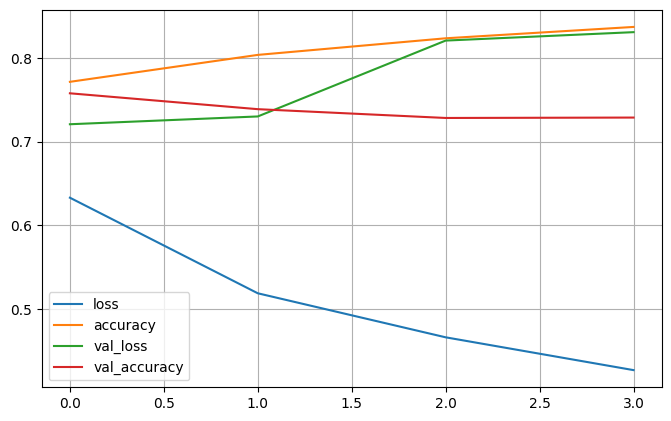

In [11]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.dpi'] = 100

def plot(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()

plot(hist)

In [12]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[1941    1   30    1  179]
 [  75 1448  226   69  521]
 [ 173   43 1135    0   57]
 [ 247  186   22  346  430]
 [ 862 1115   72  170 7352]]


In [13]:
from sklearn.metrics import f1_score

print("F1 score(macro)",f1_score(y_test, y_pred, average='macro'))
print("F1 score(micro)",f1_score(y_test, y_pred, average='micro'))

F1 score(macro) 0.6508046533884356
F1 score(micro) 0.7318124663193821


In [ ]:
### Confusion matrix Heat map
import matplotlib.pyplot as plt
import seaborn as sns
labels = (['BackChannel', 'Disruption', 'FloorGrabber', 'Question', 'Statement'])
ax = sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d')
sns.set(rc = {'figure.figsize':(19,8)})
ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()